In [1]:
library(pivottabler)
library(IRdisplay)
library(dplyr)

# 1 replication
sev.df <- read.csv('./data/djokovic/results-posts.csv', colClasses = "character")

# Small dataset
sm.df <- read.csv('./data/djokovic/results-small.csv', colClasses = "character")

# Medium (1,000) dataset
me.df <- read.csv('./data/djokovic/results-medium.csv', colClasses = "character")



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [50]:
cleanRelevancy <- function (df) {
  df$relevancy[substring(df$relevancy, 0, 2) == 'no'] <- 'no'
  df$relevancy[substring(df$relevancy, 0, 3) == 'yes'] <- 'yes'
  df$relevancy[substring(df$relevancy, 0, 7) == 'neutral'] <- 'unsure'
  df$relevancy[!(df$relevancy %in% c('no', 'yes', 'unsure'))] <- 'unsure'
  return(df)  
}

cleanSentiment <- function (df) {
  df$sentiment[substring(df$sentiment, 0, 3) == 'pro'] <- 'pro'
  df$sentiment[substring(df$sentiment, 0, 7) == 'against'] <- 'against'
  df$sentiment[substring(df$sentiment, 0, 7) == 'neutral'] <- 'neutral'
  df$sentiment[!(df$sentiment %in% c('pro', 'against', 'neutral'))] <- 'unsure'
  return(df)  
}

cleanAltResponse <- function (s) {
  return (
    gsub('(.+)answer:', '', 
      gsub('(.+)response:', '', 
        gsub('\n', '', s)
      )
    )
  )
}

cleanDF <- function (df) {
  df <- subset(df, !(author_id %in% c('18074886', '40561535')))
  df$relevancy <- sapply(df$relevancy, cleanAltResponse)
  df <- cleanRelevancy(df)
  df$sentiment <- sapply(df$sentiment, cleanAltResponse)
  df <- cleanSentiment(df)
  df$day <- as.Date(df$created_at)  
  return(df)  
}

tabling <- function (df) {
  pt <- PivotTable$new()
  pt$addData(df)
  pt$addColumnDataGroups("relevancy", totalCaption="All Relevancy")
  pt$addRowDataGroups("sentiment", totalCaption="All Sentiment")
  #pt$addColumnDataGroups("sentiment", totalCaption="All Sentiment")
  #pt$addRowDataGroups("id", totalCaption="All IDs")
  pt$defineCalculation(calculationName="Total", summariseExpression="n()")

  #pt$defineCalculation(calculationName="NA", caption="N.of Asthma hosp.", 
  #                     summariseExpression="sum(asth_n_1920, na.rm=TRUE)")
  pt$evaluatePivot()
  return(pt)
}

tablingByTweetID <- function (df) {
  pt <- PivotTable$new()
  pt$addData(df)
  pt$addColumnDataGroups("relevancy", totalCaption="All Relevancy")
  pt$addColumnDataGroups("sentiment", totalCaption="All Sentiment")
  pt$addRowDataGroups("id", totalCaption="All IDs")
  pt$defineCalculation(calculationName="Total", summariseExpression="n()")
  pt$evaluatePivot()
  return(pt)
}

tablingByAuthorID <- function (df) {
  pt <- PivotTable$new()
  pt$addData(df)
  pt$addRowDataGroups("author_id", totalCaption="All Author_IDs")
  pt$defineCalculation(calculationName="count", summariseExpression="n()")
  pt$evaluatePivot()
  return(pt)
}

getmode <- function(v) {
  uniqv <- unique(v)
  return(uniqv[which.max(tabulate(match(v, uniqv)))])
}   

tablingByTweetIDMode <- function (df) {
  pt <- PivotTable$new()
  pt$addData(df)
  pt$addRowDataGroups("id", totalCaption="All IDs")
  pt$defineCalculation(calculationName="author", summariseExpression="getmode(author_id)")
  pt$defineCalculation(calculationName="relevancy", summariseExpression="getmode(relevancy)")
  pt$defineCalculation(calculationName="sentiment", summariseExpression="getmode(sentiment)")
  pt$evaluatePivot()
  return(pt)   
}

tablingByDayTweetIDMode <- function (df) {
  pt <- PivotTable$new()
  pt$addData(df)
  pt$addRowDataGroups("id", totalCaption="All IDs")
  pt$defineCalculation(calculationName="day", summariseExpression="getmode(day)")
  pt$defineCalculation(calculationName="author", summariseExpression="getmode(author_id)")
  pt$defineCalculation(calculationName="relevancy", summariseExpression="getmode(relevancy)")
  pt$defineCalculation(calculationName="sentiment", summariseExpression="getmode(sentiment)")
  pt$evaluatePivot()
  return(pt)   
}

tablingByDay <- function (df) {
  pt <- PivotTable$new()
  pt$addData(df)
  pt$addRowDataGroups("day", totalCaption="All day")
  pt$defineCalculation(calculationName="count", summariseExpression="n()")
  pt$evaluatePivot()
  return(pt)
}

getDfByTime <- function (df) {
  pt <- tablingByDay(df)
  pt.df <-pt$asDataFrame()
  pt.df <- subset(pt.df, rownames(pt.df) != 'All day')
  pt.df$day <-rownames(pt.df)
  return(pt.df)
}    

plotByTime <- function (df, title, xlim) {
  pt.df <- getDfByTime(df)
  plot(as.Date(pt.df$day), pt.df$count, main=title, xlim=xlim, type='l', col='black', ylab='Count', xlab='Day')
  grid(nx=21)
}    

plotByTimeAdd <- function (df, title, xlim, col) {
  pt.df <- getDfByTime(df)
  lines(as.Date(pt.df$day), pt.df$count, main=title, xlim=xlim, type='l', col=col, ylab='Count', xlab='Day')
}    


In [3]:
me.df <- cleanDF(me.df)
sev.df <- cleanDF(sev.df)

In [49]:
tabling(me.df)
min(sev.df$day)
max(sev.df$day)

               no    unsure  yes  All Relevancy  
against                       83             83  
neutral                1791                1791  
pro                      13  187            200  
unsure         7919       7                7926  
All Sentiment  7919    1811  270          10000  

[1] "2021-07-12"

[1] "2022-01-20"

In [53]:
# Results with 10 replications and use of mode to choose a value
pt <- tablingByTweetIDMode(me.df)
tabling(pt$asDataFrame())

               no   unsure  yes  All Relevancy  
against                       8              8  
neutral                166    1            167  
pro                      2   19             21  
unsure         805                         805  
All Sentiment  805     168   28           1001  

In [338]:
# Results with 5 replicatons do not change much compared to the ones with 10 replications
me.strat.df <- subset(me.df, TRUE, c('id', 'relevancy', 'sentiment')) %>%
  group_by(id) %>%
  sample_n(size=5)

me.strat.df <- data.frame(me.strat.df$id, me.strat.df$relevancy, me.strat.df$sentiment) 
names(me.strat.df) <- c('id', 'relevancy', 'sentiment')

pt <- tablingByTweetIDMode(me.strat.df)
tabling(pt$asDataFrame())


               no   unsure  yes  All Relevancy  
against                       8              8  
neutral                170    1            171  
pro                      2   17             19  
unsure         802       1                 803  
All Sentiment  802     173   26           1001  

In [340]:
# Differences between 10 and 5 replications 
100 - (802 / 805) * 100
100 - (166 / 170) * 100
100 - (17 / 19) * 100

[1] 0.3726708

[1] 2.352941

[1] 10.52632

In [92]:
# 5 Replications all tweets (14,000)
sev.pt <- tabling(sev.df)
sev.pt$asDataFrame()

,no,unsure,yes,All Relevancy
,<int>,<int>,<int>,<int>
against,NA,NA,1104,1104
neutral,NA,14552,NA,14552
pro,NA,14,2229,2243
unsure,42302,9829,5,52136
All Sentiment,42302,24395,3338,70035


In [60]:
sevid.pt <- tablingByTweetIDMode(sev.df)
sevid.df <- sevid.pt$asDataFrame()
tabling(sevid.df)

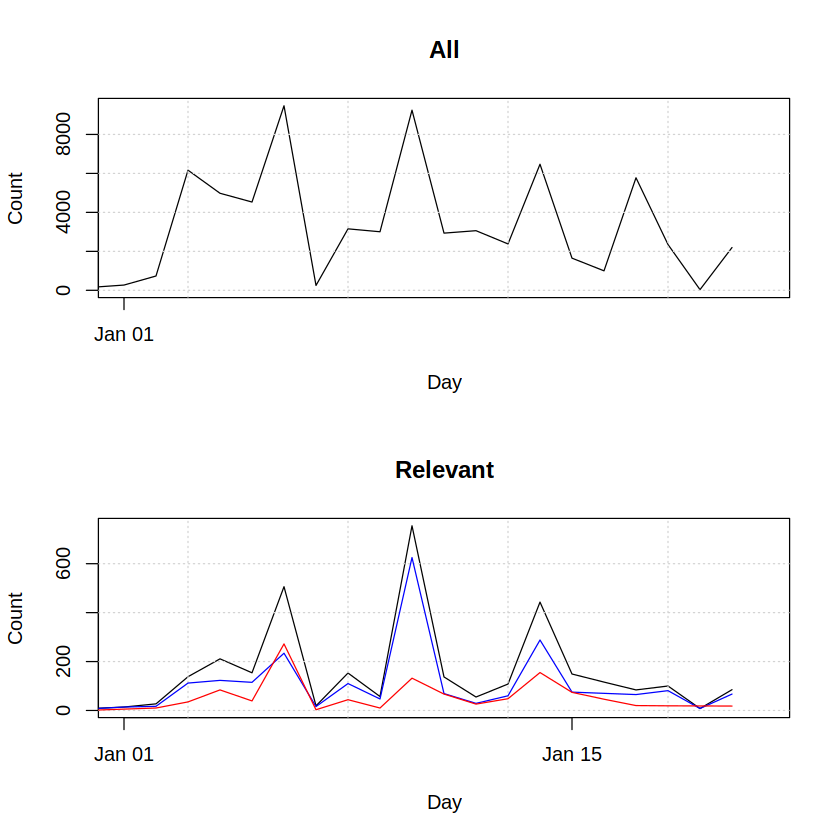

In [113]:
par(mfrow=c(2, 1))
tframe <- c(as.Date('2022-01-01'), as.Date('2022-01-21'))
#plotByTime(sev.df, 'All', tframe)

plotByTime(subset(sev.df, relevancy=='yes'), 'Relevant', tframe)
plotByTimeAdd(subset(sev.df, sentiment=='pro'), 'Pro', tframe, col='blue')
plotByTimeAdd(subset(sev.df, sentiment=='against'), 'Against', tframe, col='red')


In [6]:
sevauth.pt <- tablingByAuthorID(sev.df)
sevauth.df <- sevauth.pt$asDataFrame()

In [12]:
sevauthmode.pt <- tablingByTweetIDMode(sev.df)
sevauthmode.df <- sevauthmode.pt$asDataFrame()


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   1.000    1.000    1.000    1.856    1.000 1572.000 

[1] 7544

[1] 14001

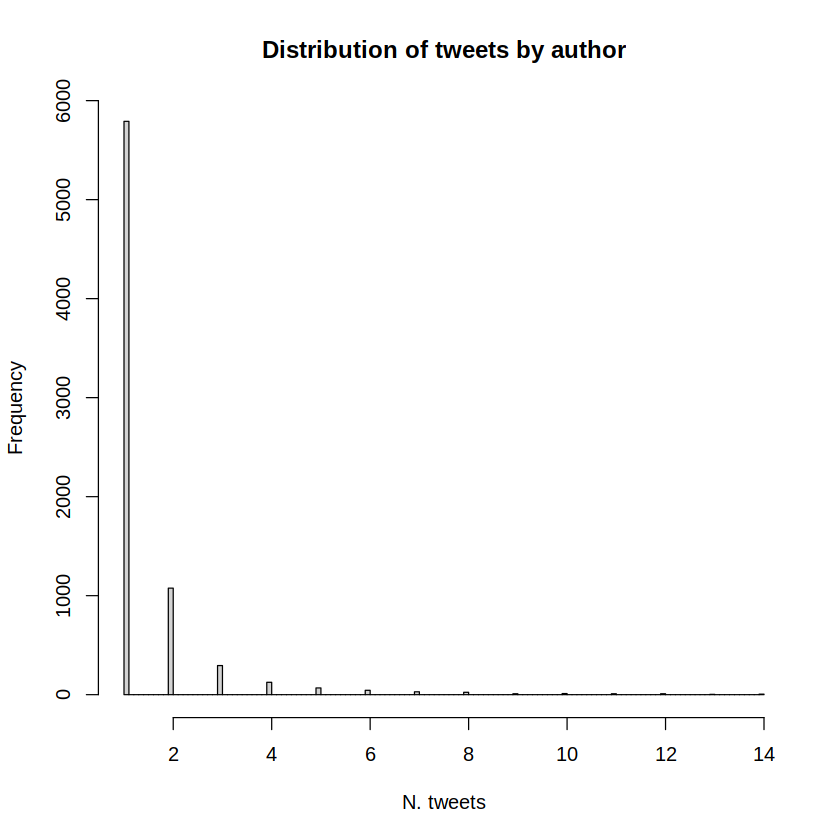

In [33]:
author.df <- (sevauthmode.df %>%
  group_by(author) %>%
  summarise(n = n()))
summary(author.df$n)
length(author.df$n)
sum(author.df$n)
hist(subset(author.df, n < 15)$n, n=100, main="Distribution of tweets by author", xlab="N. tweets" )

In [47]:
prolauth <- subset(author.df, n > 100)$author
prolauth
# grep 40561535 ~/Downloads/results-posts.csv
# "40561535","1484281070115713026","2022-01-20T21:45:58.000Z","1484281070115713026",,,"@roopeshmajeti The 8:18am Frankston to Flinders Street service has been cancelled today  Visit https://t.co/uqcPGhGUQQ for more information."
# grep 18074886 ~/Downloads/results-posts.csv
# "18074886","1483374853793411072","2022-01-18T09:44:59.000Z","1483374853793411072",,,"OFFER: BFED1 21/22 Kwinana $265 @ #Kwinana (CBH) 11.18 mt. Port: $265"

[1] "18074886" "40561535"

In [43]:
#sevidday.pt <- tablingByDayTweetIDMode(sev.df)
#sevidday.df <- sevidday.pt$asDataFrame()
sevidday.df <- (sev.df %>%
  group_by(id) %>%
  summarise(day = getmode(day), relevancy=getmode(relevancy), sentiment=getmode(sentiment)))

tabling(sevidday.df)

               no    unsure  yes  All Relevancy  
against                   7  232            239  
neutral                3175    1           3176  
pro                      27  496            523  
unsure         7924     445   16           8385  
All Sentiment  7924    3654  745          12323  

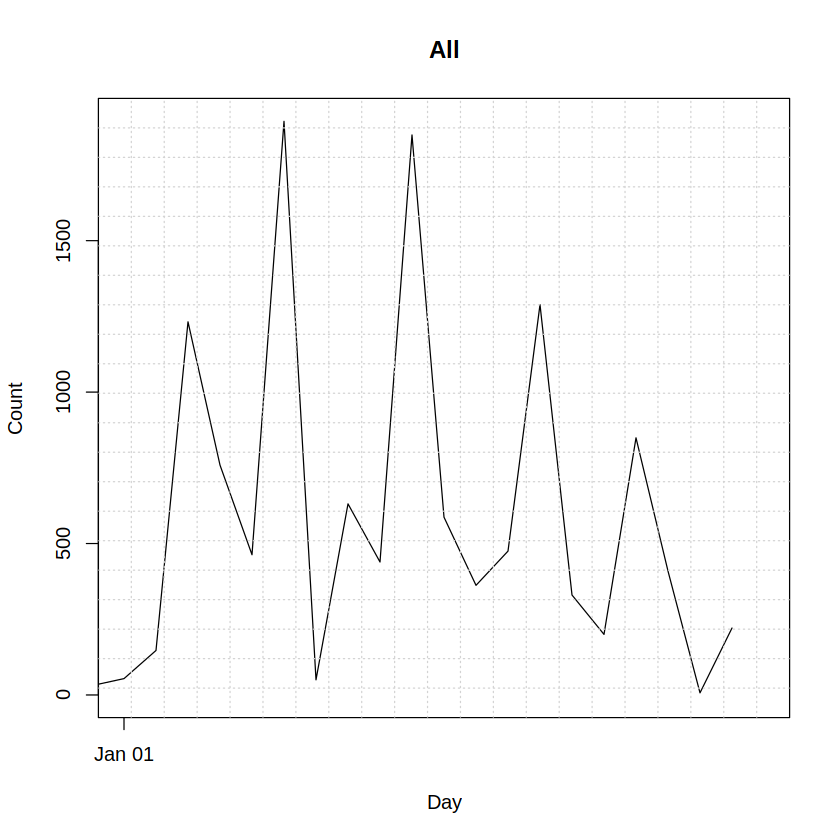

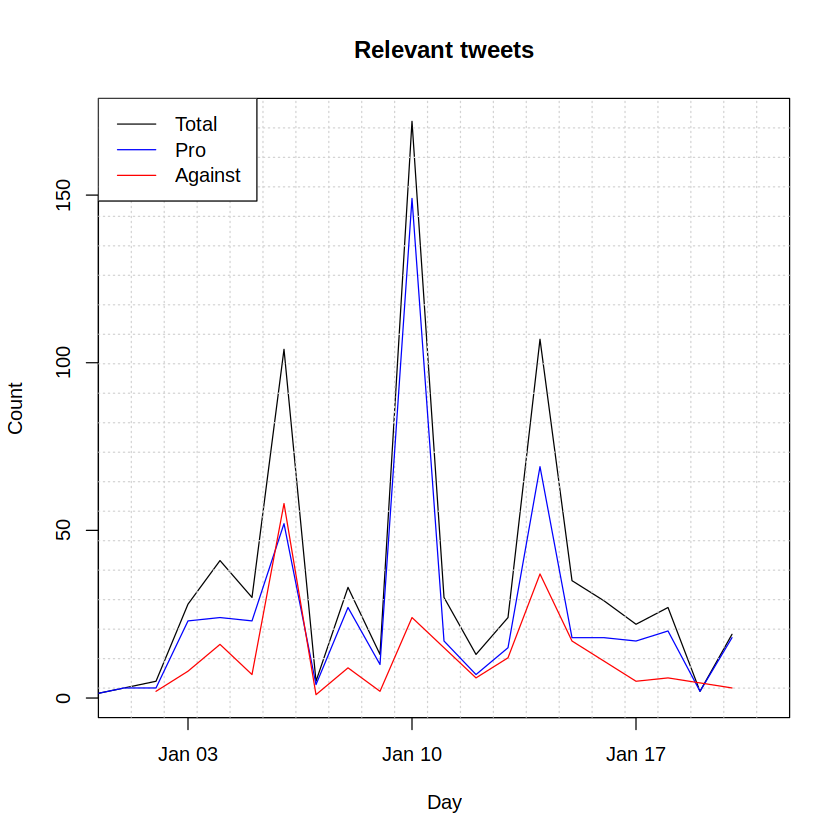

In [67]:
#par(mfrow=c(2, 1))
tframe <- c(as.Date('2022-01-01'), as.Date('2022-01-21'))
plotByTime(sevidday.df, 'All', tframe)

plotByTime(subset(sevidday.df, relevancy=='yes'), 'Relevant tweets', tframe)
plotByTimeAdd(subset(sevidday.df, sentiment=='pro'), 'Pro', tframe, col='blue')
plotByTimeAdd(subset(sevidday.df, sentiment=='against'), 'Against', tframe, col='red')
legend('topleft', legend=c('Total', 'Pro', 'Against'), col=c('black', 'blue', 'red'), lty=1)